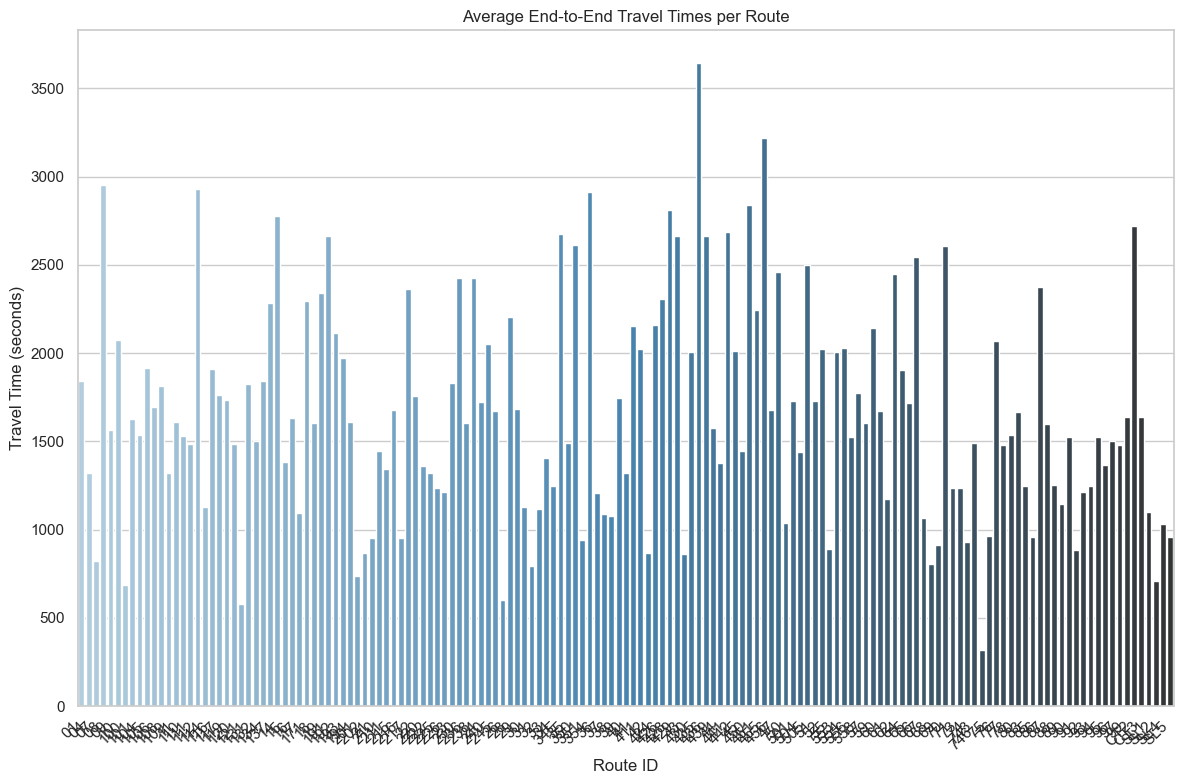

In [2]:
#visual graph of end to end service times for month of January 2022
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_end_to_end_time(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['actual', 'scheduled'])

    # Filter rows for start and end points only
    df_filtered = df[df['point_type'].isin(['Startpoint', 'Endpoint'])]

    # Group by route_id, half_trip_id, and then apply a diff function on actual time
    df_filtered = df_filtered.sort_values(by=['route_id', 'half_trip_id', 'actual'])
    df_filtered['travel_time'] = df_filtered.groupby(['route_id', 'half_trip_id'])['actual'].diff()

    # Only keep the endpoint rows which now contain the travel time in the 'travel_time' column
    df_endpoints = df_filtered[df_filtered['point_type'] == 'Endpoint']

    # Calculate mean travel time for each route
    result = df_endpoints.groupby('route_id')['travel_time'].mean()

    # Convert travel time to total seconds for plotting
    result_seconds = result.dt.total_seconds()

    return result_seconds

def plot_travel_times(result_seconds):
    # Create a bar chart using seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))
    chart = sns.barplot(x=result_seconds.index, y=result_seconds.values, palette="Blues_d")

    # Set chart title and labels
    chart.set_title('Average End-to-End Travel Times per Route')
    chart.set_ylabel('Travel Time (seconds)')
    chart.set_xlabel('Route ID')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Save the chart as an image
    plt.tight_layout()
    plt.savefig('travel_times_chart.png')
    plt.show()

# Example
filename = 'MBTA/MBTA-Bus-Arrival-Departure-Times_2022-01.csv'
travel_times = calculate_end_to_end_time(filename)
plot_travel_times(travel_times)


In [3]:
#Calculates the end to end times in hours:minutes:seconds format and cleans all null values and stores them in coorsponding .csv files for each month

import pandas as pd

def calculate_end_to_end_time(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['scheduled', 'actual'])

    # Filter rows where actual is not NaN
    df = df.dropna(subset=['actual'])

    # Calculate travel time for each trip
    df_grouped = df.groupby(['service_date', 'route_id', 'direction_id', 'half_trip_id'])

    # Finding the difference between the last and first actual time for each trip
    travel_time = df_grouped['actual'].max() - df_grouped['actual'].min()

    # Average travel time per route
    average_travel_time = travel_time.groupby('route_id').mean()

    return average_travel_time

def save_to_csv(result, month):
    # Convert the travel time to hours:minutes:seconds format and filter NaN values
    formatted_result = result.dt.total_seconds().dropna().apply(lambda x: f"{int(x // 3600)}:{int((x % 3600) // 60)}:{int(x % 60)}")
    formatted_result.to_csv(f'end_to_end_times_{month}.csv', header=['Average Travel Time'])

# Iterate through all months
for month in range(1, 13):
    filename = f'MBTA/MBTA-Bus-Arrival-Departure-Times_2022-{month:02}.csv'
    travel_times = calculate_end_to_end_time(filename)
    save_to_csv(travel_times, month)


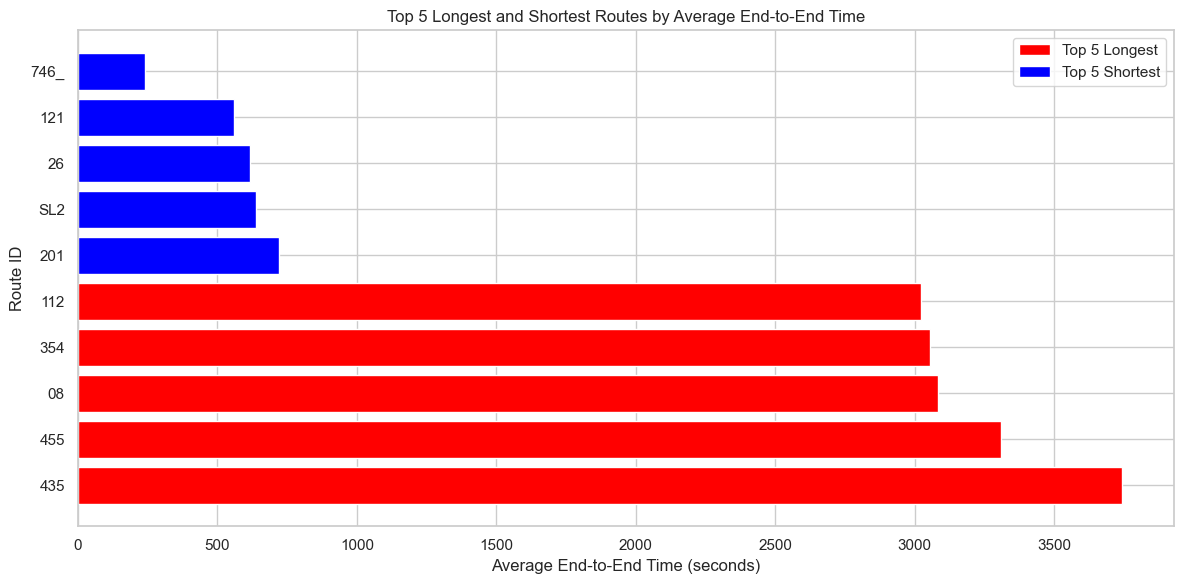

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

combined_df = pd.DataFrame()

for month in range(1, 13):
    filename = f'end_to_end_times_{month}.csv'
    df = pd.read_csv(filename)
    combined_df = pd.concat([combined_df, df])

combined_df['Average Travel Time'] = pd.to_timedelta(combined_df['Average Travel Time']).dt.total_seconds()

average_times = combined_df.groupby('route_id')['Average Travel Time'].mean().reset_index()

sorted_times = average_times.sort_values(by='Average Travel Time', ascending=False)

top_5_longest = sorted_times.head(5)
top_5_shortest = sorted_times.tail(5)

plt.figure(figsize=(12, 6))
plt.barh(top_5_longest['route_id'], top_5_longest['Average Travel Time'], color='red', label='Top 5 Longest')
plt.barh(top_5_shortest['route_id'], top_5_shortest['Average Travel Time'], color='blue', label='Top 5 Shortest')
plt.xlabel('Average End-to-End Time (seconds)')
plt.ylabel('Route ID')
plt.title('Top 5 Longest and Shortest Routes by Average End-to-End Time')
plt.legend()
plt.tight_layout()
plt.savefig('top_routes_end_to_end_time.png')
plt.show()


In [4]:
#Calculates the lateness as a percentage and outputs to .csv file
import pandas as pd

def calculate_lateness(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['scheduled', 'actual'])

    # Calculate if the bus is late
    df['late'] = (df['actual'] - df['scheduled']).dt.total_seconds() > 0

    # Group by route_id and calculate the percentage of times it's late
    route_lateness = df.groupby('route_id')['late'].mean() * 100

    return route_lateness

def save_to_csv(result):
    result.to_csv('average_route_lateness_percent_2022.csv', header=['Average Lateness Percentage'])

all_route_lateness = []

# Iterate through all months
for month in range(1,2):
    filename = f'MBTA/MBTA-Bus-Arrival-Departure-Times_2022-{month:02}.csv'
    lateness = calculate_lateness(filename)
    all_route_lateness.append(lateness)

# Combine all the monthly results and calculate the average for the year
average_lateness = pd.concat(all_route_lateness, axis=1).mean(axis=1)
save_to_csv(average_lateness)


In [5]:
#Calculates the lateness by seconds and outputs to .csv file (used for visual element)

import pandas as pd
import matplotlib.pyplot as plt

def calculate_lateness(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['scheduled', 'actual'])
    
    # Calculate lateness for each trip
    df['lateness'] = (df['actual'] - df['scheduled']).dt.total_seconds()
    
    # Average lateness per route
    average_lateness = df.groupby('route_id')['lateness'].mean()
    
    return average_lateness

def save_lateness_to_csv(result):
    result.to_csv('average_route_lateness_seconds_2022.csv', header=['Average Lateness'])

# Calculate average lateness
all_lateness_data = []
for month in range(1, 13):
    filename = f'MBTA/MBTA-Bus-Arrival-Departure-Times_2022-{month:02}.csv'
    lateness = calculate_lateness(filename)
    all_lateness_data.append(lateness)

# Combine monthly data and compute overall average for the year
total_lateness = pd.concat(all_lateness_data, axis=1).mean(axis=1)
save_lateness_to_csv(total_lateness)


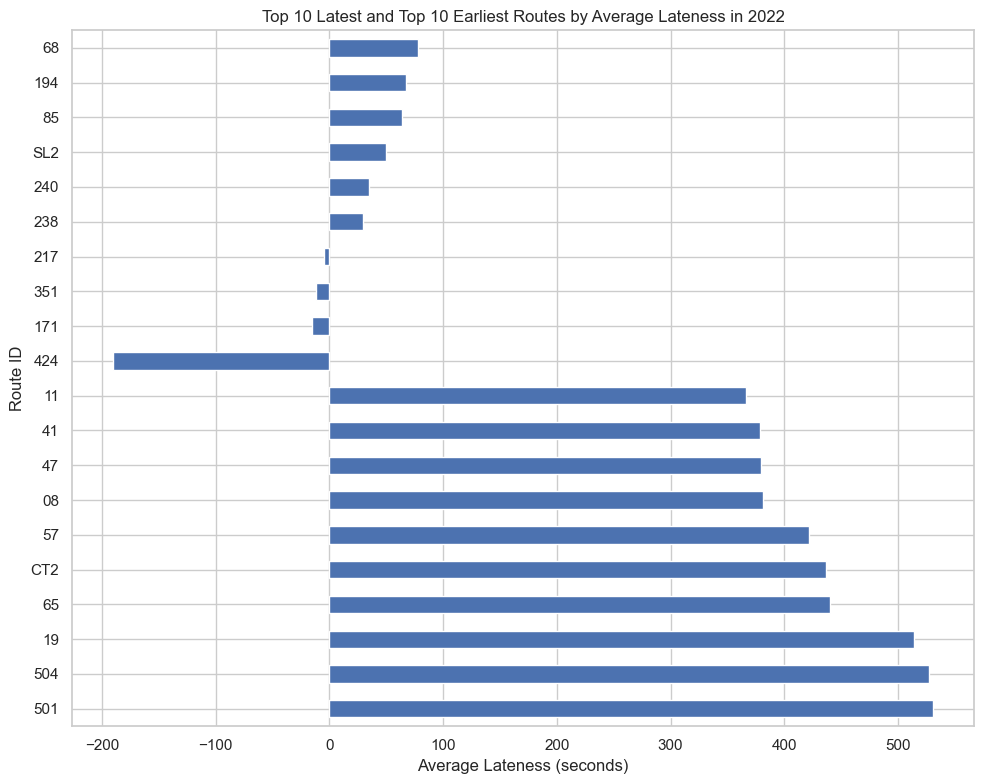

In [11]:
#Visual graph of average lateness for year of 2022 by bus route id's
def visualize_lateness():
    # Read the lateness data
    lateness_df = pd.read_csv('average_route_lateness_seconds_2022.csv', index_col='route_id')
    
       # Sort lateness data by 'Average Lateness' in descending order to get the top 10 latest routes
    top_10_latest = lateness_df.sort_values(by='Average Lateness', ascending=False).head(10)
    
    # Sort lateness data by 'Average Lateness' in ascending order to get the top 10 earliest routes
    top_10_earliest = lateness_df.sort_values(by='Average Lateness').head(10)
    
    # Concatenate the dataframes to combine the top 10 latest and top 10 earliest routes
    combined_df = pd.concat([top_10_latest, top_10_earliest])

    # Plot the combined data
    combined_df.plot(kind='barh', figsize=(10, 8), legend=False)
    plt.title('Top 10 Latest and Top 10 Earliest Routes by Average Lateness in 2022')
    plt.xlabel('Average Lateness (seconds)')
    plt.ylabel('Route ID')
    plt.tight_layout()
    plt.savefig('top_lateness_routes_2022_plot.png')
    plt.show()

visualize_lateness()


In [14]:
df_from_csv = pd.read_csv("average_route_lateness_percent_2022.csv")

# Sort the dataframe by 'Average Lateness Percentage' in descending order to get top 10
sorted_df_from_csv = df_from_csv.sort_values(by='Average Lateness Percentage', ascending=False).head(10)
sorted_df_from_csv

,route_id,Average Lateness Percentage
36,193,88.888889
145,CT2,87.512371
13,11,85.070365
55,24,84.741800
40,21,84.418016
114,65,84.052068
102,52,82.754777
3,08,82.654756
122,74,82.425094
97,50,82.115385


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_unique_ids(dataframe):
    # Count the unique half_trip_ids for each route_id
    unique_ids_count = dataframe.groupby('route_id')['half_trip_id'].nunique()
    return unique_ids_count

def plot_unique_ids(unique_ids_count):
    # Create a bar chart using seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))
    chart = sns.barplot(x=unique_ids_count.index, y=unique_ids_count.values, palette="Blues_d")

    # Set chart title and labels
    chart.set_title('Number of Unique IDs per Route')
    chart.set_ylabel('Count of Unique IDs')
    chart.set_xlabel('Route ID')

    # Save the chart as an image
    plt.tight_layout()
    plt.savefig('unique_ids_chart.png')
    plt.show()

# This would be where you load your dataframe
# Initialize a DataFrame to hold the combined data
monthly_unique_ids = pd.DataFrame()

# Loop over the months
for month in range(1, 13):
    # Construct the filename for each month
    filename = f'MBTA/MBTA-Bus-Arrival-Departure-Times_2022-{month:02d}.csv'
    
    # Load the data
    df_month = pd.read_csv(filename)
    
    # Calculate the unique IDs for the month
    unique_ids_month = calculate_unique_ids(df_month)
    
    # Add the result to the monthly_unique_ids DataFrame
    monthly_unique_ids = monthly_unique_ids.append(unique_ids_month, ignore_index=True)

# Now calculate the average number of unique IDs per route over all months
average_unique_ids = monthly_unique_ids.mean(axis=0)

# Print the average counts for each route
print(average_unique_ids)

# Optionally, plot the average counts
# plot_unique_ids(average_unique_ids)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8260\4066205176.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  monthly_unique_ids = monthly_unique_ids.append(unique_ids_month, ignore_index=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8260\4066205176.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  monthly_unique_ids = monthly_unique_ids.append(unique_ids_month, ignore_index=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8260\4066205176.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  monthly_unique_ids = monthly_unique_ids.append(unique_ids_month, ignore_index=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8260\4066205176.py:42: FutureWarning: The frame.append method is deprecated and will be remove

route_id
01     6768.500000
04      506.000000
07     3598.583333
08     2128.083333
09     4715.250000
          ...     
CT3    1184.416667
SL1    6339.750000
SL2    5738.166667
SL4    5168.916667
SL5    7726.583333
Length: 151, dtype: float64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8260\4066205176.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  monthly_unique_ids = monthly_unique_ids.append(unique_ids_month, ignore_index=True)


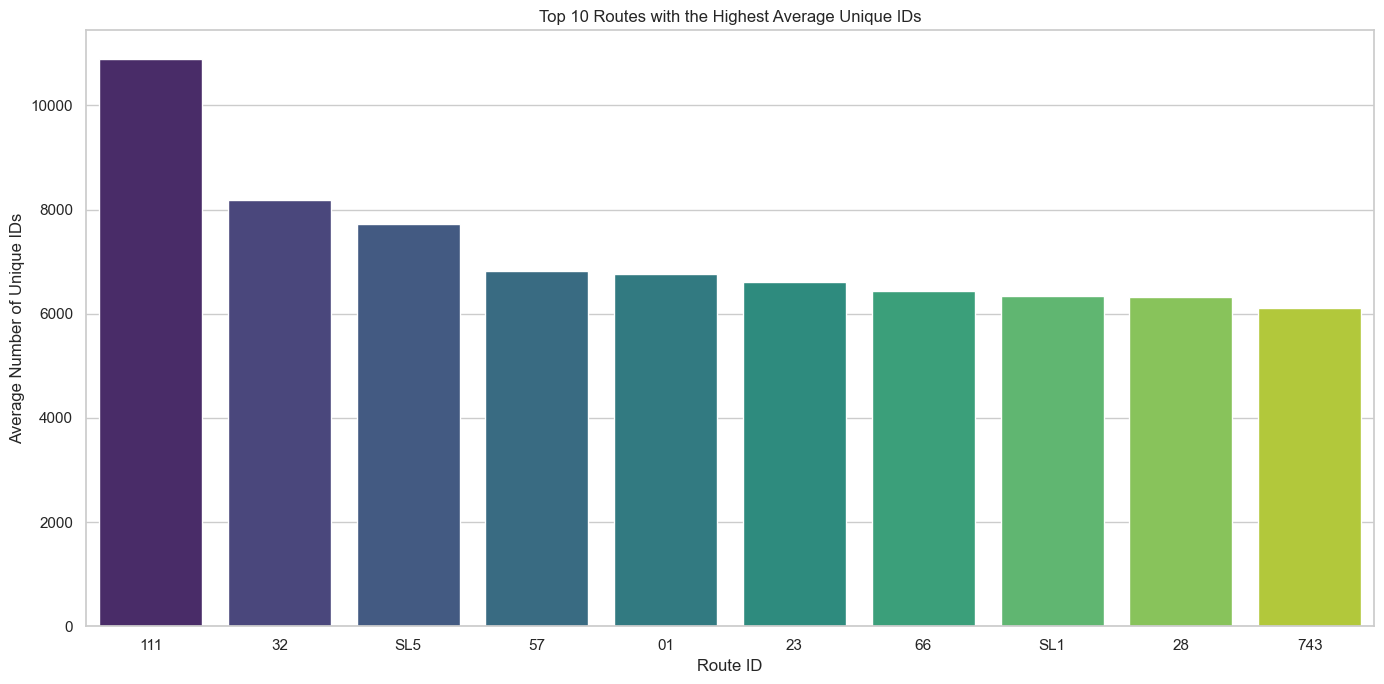

In [23]:
top10_average_unique_ids = average_unique_ids.sort_values(ascending=False).head(10)
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
chart = sns.barplot(x=top10_average_unique_ids.index, y=top10_average_unique_ids.values, palette="viridis")

# Set chart title and labels
chart.set_title('Top 10 Routes with the Highest Average Unique IDs')
chart.set_ylabel('Average Number of Unique IDs')
chart.set_xlabel('Route ID')

# Save the chart as an image
plt.tight_layout()
plt.savefig('top10_unique_ids_chart.png')

# Show the plot
plt.show()


In [29]:
print(average_unique_ids)
average_unique_ids_str = average_unique_ids.to_string()

# Define the path for the txt file
txt_file_path = 'average_unique_ids.txt'

# Save the string to a txt file
with open(txt_file_path, 'w') as file:
    file.write(average_unique_ids_str)

route_id
01     6768.500000
04      506.000000
07     3598.583333
08     2128.083333
09     4715.250000
          ...     
CT3    1184.416667
SL1    6339.750000
SL2    5738.166667
SL4    5168.916667
SL5    7726.583333
Length: 151, dtype: float64


In [3]:
import pandas as pd
data = pd.read_csv("PATI_Bus_Stops.csv", low_memory=False)
print(data["Routes"].unique())

['43' '22, 29' '15, 19, 23, 28, 44, 45, 66' '22, 29, 44' '65'
 '65, 66, 501' '66' '35, 39, 66' '32, 34, 36, 44' '44'
 '32, 34, 36, 38, 44' '19, 66' '10' '55' '69' '68, 83' '70' '15, 17'
 '15, 16, 17' '15, 41' '15, 41, 45' '15' '8, 19, 60, 65' '60, 65' '65, 66'
 '60' '51, 60' '60, 65, 66' '8, 9, 19, 60, 65' '10, 16, 23, 45' '45'
 '16, 32, 34, 36, 38, 45' '70, 86' '8, 19, 47' '61' '40, 4050' '40' '238'
 '350' '350, 354' '28, 29' '28, 29, 31' '22, 28, 29, 45'
 '22, 29, 32, 34, 36' '14' '47' '47, 747' '8, 19, 47, 60, 65'
 '8, 19, 47, 60, 65, 747' '8, 19, 47, 747'
 '8, 9, 19, 22, 28, 47, 708, 747' '8, 9, 19, 22, 28, 47' '8, 15, 749, 751'
 '8' '8, 47, 708' '8, 47' '8, 19, 47, 708' '9, 19' '8, 9, 19, 47, 60, 65'
 '8, 9, 19, 47, 60, 65, 708, 747' '47, 57, 747' '51' '52, 57, 504'
 '55, 57' '38, 39' '35, 39, 41' '35, 38' '35, 38, 39' '71, 73' '71'
 '71, 73, 74, 75, 77, 78, 96' '71, 75' '75' '73, 554' '73' '4' '74, 75'
 '74, 78' '74, 75, 78' '68, 69' '66, 68, 69' '68' '64, 68, 85' '77'
 '67, 77' 